# 2024-026 Differential Peak Analysis

This notebook describes steps to perform differential peak analysis of ATAC-seq data.

## Initialize Enviroment

In [1]:
# Load Libraries
library(DESeq2)
library(ggplot2)
library(dplyr)
library(tidyr)

# Load data
exp_dir     <- "/home/dalbao/2024-026-Tcf7ATAC"
nfcore_dir  <- "01_nfcore_241228"
nb_dir      <- "02_bp_notebooks"
prefix      <- "DAnST-DAPS_noShrink"                                   # bp for broad peak calling settings

# Experiments to analyze
exp <- c("DA", "ST")

# Comparisons
comp_file <- "metadata/comparisons.csv"

# Annotations
anno_file <- "250113-bp-peakAnno-Filtered.csv"
# Add folder structure to anno_file
anno_file <- paste(nfcore_dir, anno_file, sep = "/")

# Filter file
filter_file <- "241231-bp-peakFilter.txt"
# Add folder structure to filter_file
filter_file <- paste(nfcore_dir, filter_file, sep = "/")

# nf-core ATAC-seq pipeline calls peaks from two different libraries:
library     <- "merged_library"
# If library == merged_library, lib_sh is mLb
# else if it is == merged_replicates, lib_sh is mRp
lib_sh      <- ifelse(library == "merged_library", "mLb", "mRp")

# nf-core ATAC-seq pipeline calls peaks in two types, broad_peak and narrow_peak:
peak_type   <- "broad_peak"
# If peak_type == broad_peak, peak_sh is bp
peak_sh     <- ifelse(peak_type == "broad_peak", "bp", "np")

# Add peak type and date to prefix
prefix <- paste0(format(Sys.Date(), "%y%m%d"), "-", peak_sh, "-", prefix)

# Move to working directory
setwd(exp_dir)

Loading required package: S4Vectors

Loading required package: stats4

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
    colnames, dirname, do.call, duplicated, eval, evalq, Filter, Find,
    get, grep, grepl, intersect, is.unsorted, lapply, Map, mapply,
    match, mget, order, paste, pmax, pmax.int, pmin, pmin.int,
    Position, rank, rbind, Reduce, rownames, sapply, saveRDS, setdiff,
    table, tapply, union, unique, unsplit, which.max, which.min



Attaching package: ‘S4Vectors’


The following object is masked from ‘package:utils’:

    findMatches


The following objects are masked from ‘package:base’:

    expand.grid, I, unname


Loading required package: IRanges

Loading required package: GenomicRanges

Loading required package: GenomeInfoDb



In [2]:
# Find featre counts file
featureCounts <- paste( nfcore_dir,
                        "/bwa/",
                        library,
                        "/macs2/",
                        peak_type,
                        "/consensus/",
                        "consensus_peaks.", lib_sh, ".clN.featureCounts.txt", sep = "")

# Load feature counts
featureCounts <- read.table(featureCounts,
                            header = TRUE)

# Remove unnecessary columns
featureCounts <- featureCounts[, -c(2:6)]

# Rename columns
sample_suffix <- paste0(".", lib_sh, ".clN.sorted.bam")
colnames(featureCounts) <- gsub(sample_suffix, "", colnames(featureCounts))

# Make intervals as row names
rownames(featureCounts) <- featureCounts$Geneid
featureCounts <- featureCounts[, -1]

# Check
head(featureCounts)

,DW_WT_24h_REP2,DW_RUNX3KO_0h_REP2,DW_WT_12h_REP2,Tcm_WT_REP1,DW_RUNX3KO_2h_REP2,DW_RUNX3KO_6h_REP2,Effector_REP2,DW_RUNX3KO_6h_REP1,DW_RUNX3KO_0h_REP1,DW_WT_0h_REP1,⋯,GFPneg_d28_REP3,GFPneg_d28_REP1,GFPpos_d8_REP1,GFPneg_d8_REP3,GFPpos_d8_REP2,GFPneg_d8_REP2,GFPneg_d28_REP2,GFPpos_d28_REP1,GFPneg_d8_REP1,DW_WT_6h_REP2
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
Interval_1,2,0,2,0,2,1,2,0,2,1,⋯,5,4,5,4,6,3,2,4,7,7
Interval_2,2,1,10,0,0,2,2,1,2,3,⋯,8,2,5,6,10,7,9,5,7,15
Interval_3,1,1,1,0,3,1,1,0,1,2,⋯,3,2,2,2,2,1,2,5,3,5
Interval_4,1,1,2,0,0,0,0,0,0,0,⋯,4,1,4,1,3,4,1,8,0,3
Interval_5,2,1,0,0,1,2,0,0,0,1,⋯,5,4,5,4,6,1,6,7,6,6
Interval_6,3,3,1,0,1,1,0,0,5,2,⋯,10,2,2,5,0,4,3,8,5,8


In [3]:
# Load sample metadata
sampleMetadata <- read.csv("metadata/sampleMetadata.csv")

# Make sample names as row names
rownames(sampleMetadata) <- sampleMetadata$Sample
sampleMetadata <- sampleMetadata[, -1]

# Check
head(sampleMetadata)

# Make sure the observations in sampleMetadata are in the same order as the columns in featureCounts
sampleMetadata <- sampleMetadata[colnames(featureCounts), ]

# Load keep peaks file
keep <- read.table(filter_file, header = TRUE)
keep <- keep[keep$keep == TRUE, ]

# Keep only features (identified by rowname) that are in keep$interval_id
featureCounts <- featureCounts[rownames(featureCounts) %in% keep$interval_id, ]
head(featureCounts)

,Experiment,Condition,Phenotype,Transduction,Rep,DW_time,DW_genotype,Time,Genotype,Batch
,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<chr>,<int>,<chr>,<chr>
DW_WT_24h_REP2,DW,DW_WT_24h,,,REP2,24,WT,NA,,
DW_RUNX3KO_0h_REP2,DW,DW_RUNX3KO_0h,,,REP2,0,RUNX3KO,NA,,
DW_RUNX3KO_6h_REP1,DW,DW_RUNX3KO_6h,,,REP1,6,RUNX3KO,NA,,
DW_WT_6h_REP1,DW,DW_WT_6h,,,REP1,6,WT,NA,,
CX3CR1pos_shRunx3_REP2,DA,CX3CR1pos_shRunx3,CX3CR1pos,shRunx3,,NA,,NA,,B
DW_WT_0h_REP1,DW,DW_WT_0h,,,REP1,0,WT,NA,,


,DW_WT_24h_REP2,DW_RUNX3KO_0h_REP2,DW_WT_12h_REP2,Tcm_WT_REP1,DW_RUNX3KO_2h_REP2,DW_RUNX3KO_6h_REP2,Effector_REP2,DW_RUNX3KO_6h_REP1,DW_RUNX3KO_0h_REP1,DW_WT_0h_REP1,⋯,GFPneg_d28_REP3,GFPneg_d28_REP1,GFPpos_d8_REP1,GFPneg_d8_REP3,GFPpos_d8_REP2,GFPneg_d8_REP2,GFPneg_d28_REP2,GFPpos_d28_REP1,GFPneg_d8_REP1,DW_WT_6h_REP2
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
Interval_98,17,32,33,35,12,14,80,3,27,61,⋯,234,224,212,147,176,165,240,364,177,128
Interval_103,29,5,28,22,8,9,51,1,3,13,⋯,183,160,117,172,132,179,242,157,216,66
Interval_105,22,37,23,5,33,47,27,9,29,20,⋯,146,133,81,66,80,97,139,117,95,165
Interval_107,12,12,11,4,15,18,26,6,16,19,⋯,82,73,61,49,59,56,86,73,80,131
Interval_108,108,224,160,110,222,194,174,39,247,244,⋯,858,707,482,449,536,594,751,676,531,975
Interval_110,172,210,274,158,274,271,158,57,264,252,⋯,942,771,527,495,480,648,909,740,633,1388


## Perform Analysis on DA Experiment

In [4]:
# DA experiment is tagged as DA in sampleMetadata
daMeta <- sampleMetadata[sampleMetadata$Experiment %in% exp, ]
daExp  <- featureCounts[, colnames(featureCounts) %in% rownames(daMeta), ]

# Check one-to-one correspondence
all(rownames(daMeta) == colnames(daExp))

# Check
head(daMeta)
head(daExp)

[1] TRUE

,Experiment,Condition,Phenotype,Transduction,Rep,DW_time,DW_genotype,Time,Genotype,Batch
,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<chr>,<int>,<chr>,<chr>
CX3CR1pos_shCD19_REP2,DA,CX3CR1pos_shCD19,CX3CR1pos,shCD19,,NA,,NA,,B
CX3CR1pos_shRunx3_REP2,DA,CX3CR1pos_shRunx3,CX3CR1pos,shRunx3,,NA,,NA,,B
GFPpos_shCD19_REP2,DA,GFPpos_shCD19,GFPpos,shCD19,,NA,,NA,,B
CX3CR1pos_shRunx3_REP1,DA,CX3CR1pos_shRunx3,CX3CR1pos,shRunx3,,NA,,NA,,A
GFPneg_shCD19_REP1,DA,GFPneg_shCD19,GFPneg,shCD19,,NA,,NA,,A
GFPpos_shCD19_REP1,DA,GFPpos_shCD19,GFPpos,shCD19,,NA,,NA,,A


,CX3CR1pos_shCD19_REP2,CX3CR1pos_shRunx3_REP2,GFPpos_shCD19_REP2,CX3CR1pos_shRunx3_REP1,GFPneg_shCD19_REP1,GFPpos_shCD19_REP1,D5_shRunx3_REP1,D5_shRunx3_REP2,GFPpos_shRunx3_REP1,GFPneg_shRunx3_REP2,GFPneg_shRunx3_REP1,D5_shCD19_REP2,naive_REP2,naive_REP1,GFPneg_shCD19_REP2,CX3CR1pos_shCD19_REP1,GFPpos_shRunx3_REP2,D5_shCD19_REP1
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
Interval_98,76,39,54,64,51,34,74,91,32,66,44,123,58,76,95,57,98,123
Interval_103,77,26,28,89,24,39,115,86,28,31,34,122,13,19,59,77,41,182
Interval_105,45,8,21,57,21,33,20,34,21,29,19,33,34,34,36,41,37,39
Interval_107,42,8,25,46,16,34,24,26,24,25,25,28,21,33,42,36,51,35
Interval_108,374,160,421,531,470,538,365,427,478,349,466,405,479,650,565,550,531,488
Interval_110,317,119,355,417,335,409,392,450,307,284,351,480,370,516,426,360,412,486


Create the DESeq2 object:

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”
estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing

using ntop=500 top features by variance



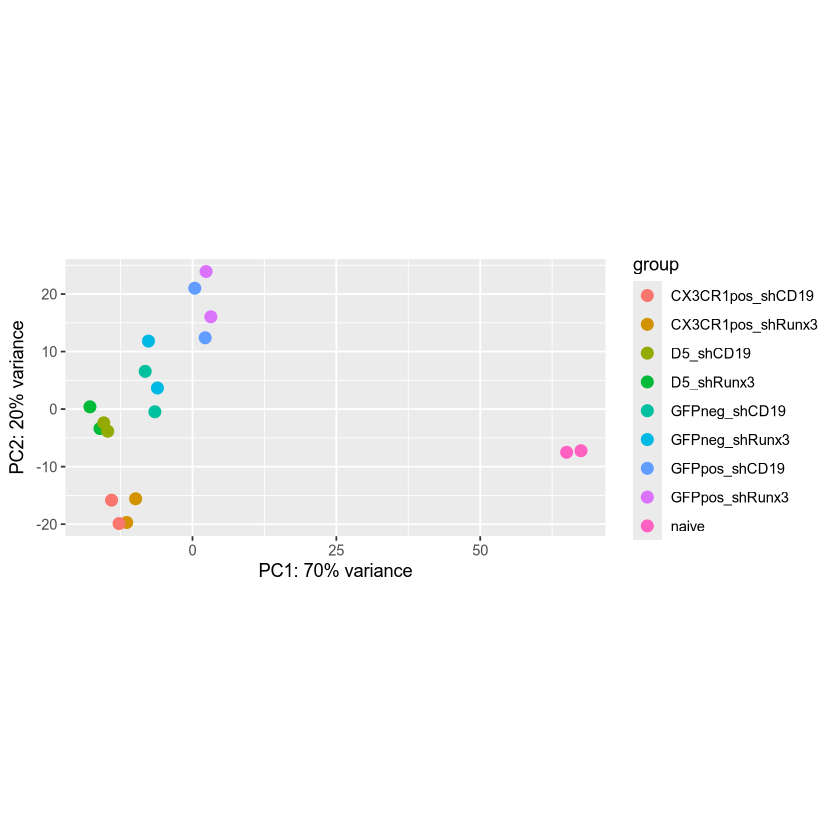

In [5]:
# Create DESeq object
dds <- DESeqDataSetFromMatrix(  countData = daExp,
                                colData   = daMeta,
                                design    = ~ Condition)

# Process DESeq
dds <- DESeq(dds)

# Plot PCA
vst_data <- vst(dds, blind = TRUE)
plotPCA(vst_data, intgroup = c("Condition"))

## Perform Individual Comparisons

In [6]:
# Load comparisons CSV
comparisons <- read.csv(comp_file)

# Initialize an empty list to store results dataframes
results <- list()

# Loop over each row in the comparisons dataframe to perform differential expression analysis
for ( i in 1:nrow(comparisons) ) {
  # Perform differential expression analysis using DESeq2 (or similar) for the current comparison
  # The contrast is set using the 'Condition' column, comparing the numerator vs the denominator
  # res <- lfcShrink( dds,
  #                   contrast = c("Condition", comparisons$Numerator[i], comparisons$Denominator[i]),
  #                   type = "ashr")
  # The contrast is set using the 'sample' column, comparing the numerator vs the denominator
  stat <- results(dds, contrast = c("Condition", comparisons$Numerator[i], comparisons$Denominator[i]))

  # Create a dataframe from the results object for the current comparison
  # Include comparison identifiers, statistical results, and gene names
  results[[comparisons$Comparison[i]]] <- data.frame(
    comparison = comparisons$Comparison[i],
    numerator = comparisons$Numerator[i],
    denominator = comparisons$Denominator[i],
    name = rownames(stat),
    baseMean = stat$baseMean,
    log2FC = stat$log2FoldChange,
    statistic = stat$stat,
    pvalue = stat$pvalue,
    padj = stat$padj
  )

  # Remove rows with any missing values to ensure clean data
  results[[comparisons$Comparison[i]]] <- results[[comparisons$Comparison[i]]][complete.cases(results[[comparisons$Comparison[i]]]), ]
  # Order the results by the statistic in decreasing order for prioritization
  results[[comparisons$Comparison[i]]] <- results[[comparisons$Comparison[i]]][order(results[[comparisons$Comparison[i]]]$statistic, decreasing = TRUE), ]

  # Cleanup: Remove temporary variables to free memory (though removing 'i' is not necessary)
  rm(stat, i)
}

# Combine all individual comparison result dataframes into a single dataframe
results_individual <- bind_rows(results)

# View
head(results_individual)

,comparison,numerator,denominator,name,baseMean,log2FC,statistic,pvalue,padj
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,CX3CR1pos_shCD19,CX3CR1pos_shCD19,naive,Interval_229397,934.6985,5.350193,25.72252,6.544443e-146,3.088454e-141
2,CX3CR1pos_shCD19,CX3CR1pos_shCD19,naive,Interval_146480,900.7048,4.571466,25.61200,1.121508e-144,2.646310e-140
3,CX3CR1pos_shCD19,CX3CR1pos_shCD19,naive,Interval_32210,1258.9194,3.921214,25.31085,2.426120e-141,3.816448e-137
4,CX3CR1pos_shCD19,CX3CR1pos_shCD19,naive,Interval_216889,1177.5073,3.452492,25.16240,1.033996e-139,1.219909e-135
5,CX3CR1pos_shCD19,CX3CR1pos_shCD19,naive,Interval_4683,856.9725,5.339564,23.81299,2.450326e-125,2.312716e-121
6,CX3CR1pos_shCD19,CX3CR1pos_shCD19,naive,Interval_51104,1094.8877,3.804722,23.18159,6.983693e-119,5.492908e-115


## Perform Combined Comparisons

[1] TRUE

,Experiment,Condition,Phenotype,Transduction,Rep,DW_time,DW_genotype,Time,Genotype,Batch
,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<chr>,<int>,<chr>,<chr>
CX3CR1pos_shCD19_REP2,DA,CX3CR1pos_shCD19,CX3CR1pos,shCD19,,NA,,NA,,B
CX3CR1pos_shRunx3_REP2,DA,CX3CR1pos_shRunx3,CX3CR1pos,shRunx3,,NA,,NA,,B
GFPpos_shCD19_REP2,DA,GFPpos_shCD19,GFPpos,shCD19,,NA,,NA,,B
CX3CR1pos_shRunx3_REP1,DA,CX3CR1pos_shRunx3,CX3CR1pos,shRunx3,,NA,,NA,,A
GFPneg_shCD19_REP1,DA,GFPneg_shCD19,GFPneg,shCD19,,NA,,NA,,A
GFPpos_shCD19_REP1,DA,GFPpos_shCD19,GFPpos,shCD19,,NA,,NA,,A


,CX3CR1pos_shCD19_REP2,CX3CR1pos_shRunx3_REP2,GFPpos_shCD19_REP2,CX3CR1pos_shRunx3_REP1,GFPneg_shCD19_REP1,GFPpos_shCD19_REP1,GFPpos_shRunx3_REP1,GFPneg_shRunx3_REP2,GFPneg_shRunx3_REP1,GFPneg_shCD19_REP2,CX3CR1pos_shCD19_REP1,GFPpos_shRunx3_REP2
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
Interval_98,76,39,54,64,51,34,32,66,44,95,57,98
Interval_103,77,26,28,89,24,39,28,31,34,59,77,41
Interval_105,45,8,21,57,21,33,21,29,19,36,41,37
Interval_107,42,8,25,46,16,34,24,25,25,42,36,51
Interval_108,374,160,421,531,470,538,478,349,466,565,550,531
Interval_110,317,119,355,417,335,409,307,284,351,426,360,412


Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”
estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing

using ntop=500 top features by variance



,Denominator,Numerator,Comparison,Coefficient
,<chr>,<chr>,<chr>,<chr>
1,shCD19,shRunx3,shRunx3_vs_shCD19,Transduction
2,GFPpos,GFPneg,GFPneg_vs_GFPpos,Phenotype
3,GFPpos,CX3CR1pos,CX3CR1pos_vs_GFPpos,Phenotype
4,GFPneg,CX3CR1pos,CX3CR1pos_vs_GFPneg,Phenotype


,comparison,numerator,denominator,name,baseMean,log2FC,statistic,pvalue,padj
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,CX3CR1pos_shCD19,CX3CR1pos_shCD19,naive,Interval_229397,934.6985,5.350193,25.72252,6.544443e-146,3.088454e-141
2,CX3CR1pos_shCD19,CX3CR1pos_shCD19,naive,Interval_146480,900.7048,4.571466,25.61200,1.121508e-144,2.646310e-140
3,CX3CR1pos_shCD19,CX3CR1pos_shCD19,naive,Interval_32210,1258.9194,3.921214,25.31085,2.426120e-141,3.816448e-137
4,CX3CR1pos_shCD19,CX3CR1pos_shCD19,naive,Interval_216889,1177.5073,3.452492,25.16240,1.033996e-139,1.219909e-135
5,CX3CR1pos_shCD19,CX3CR1pos_shCD19,naive,Interval_4683,856.9725,5.339564,23.81299,2.450326e-125,2.312716e-121
6,CX3CR1pos_shCD19,CX3CR1pos_shCD19,naive,Interval_51104,1094.8877,3.804722,23.18159,6.983693e-119,5.492908e-115


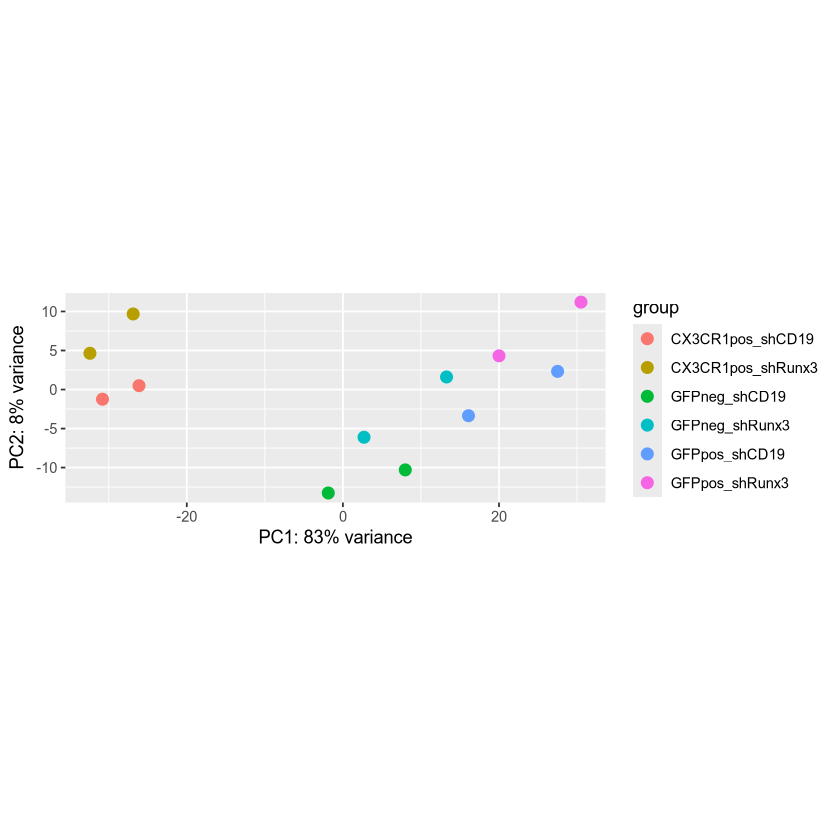

In [7]:
# DA experiment is tagged as DA in sampleMetadata
daMeta <- sampleMetadata[sampleMetadata$Condition != "naive" & sampleMetadata$Experiment == exp[1], ]
daExp  <- featureCounts[, colnames(featureCounts) %in% rownames(daMeta), ]

# Check one-to-one correspondence
all(rownames(daMeta) == colnames(daExp))

# Check
head(daMeta)
head(daExp)

# Create DESeq object
dds <- DESeqDataSetFromMatrix(countData = daExp,
                              colData   = daMeta,
                              design    = ~ Phenotype + Transduction)

# Process DESeq
dds <- DESeq(dds)

# Plot PCA
vst_data <- vst(dds, blind = TRUE)
plotPCA(vst_data, intgroup = c("Condition"))

# Load comparisons CSV
comparisons <- read.csv("metadata/comparisons_da_combined.csv")

head(comparisons)

# Initialize an empty list to store results dataframes
results <- list()

# Loop over each row in the comparisons dataframe to perform differential expression analysis
for ( i in 1:nrow(comparisons) ) {
  # Perform differential expression analysis using DESeq2 (or similar) for the current comparison
  # The contrast is set using the 'Condition' column, comparing the numerator vs the denominator
  # res <- lfcShrink( dds,
  #                   contrast = c(comparisons$Coefficient[i], comparisons$Numerator[i], comparisons$Denominator[i]),
  #                   type = "ashr")
  # The contrast is set using the 'sample' column, comparing the numerator vs the denominator
  stat <- results(dds, contrast = c(comparisons$Coefficient[i], comparisons$Numerator[i], comparisons$Denominator[i]))

  # Create a dataframe from the results object for the current comparison
  # Include comparison identifiers, statistical results, and gene names
  results[[comparisons$Comparison[i]]] <- data.frame(
    comparison = comparisons$Comparison[i],
    numerator = comparisons$Numerator[i],
    denominator = comparisons$Denominator[i],
    name = rownames(stat),
    baseMean = stat$baseMean,
    log2FC = stat$log2FoldChange,
    statistic = stat$stat,
    pvalue = stat$pvalue,
    padj = stat$padj
  )

  # Remove rows with any missing values to ensure clean data
  results[[comparisons$Comparison[i]]] <- results[[comparisons$Comparison[i]]][complete.cases(results[[comparisons$Comparison[i]]]), ]
  # Order the results by the statistic in decreasing order for prioritization
  results[[comparisons$Comparison[i]]] <- results[[comparisons$Comparison[i]]][order(results[[comparisons$Comparison[i]]]$statistic, decreasing = TRUE), ]

  # Cleanup: Remove temporary variables to free memory (though removing 'i' is not necessary)
  rm(stat, i)
}

# Combine all individual comparison result dataframes into a single dataframe
results <- bind_rows(results)

results <- rbind.data.frame(results, results_individual)

# View
head(results_individual)

In [8]:
# Write the combined results dataframe to a CSV file without row names
fn <- paste0(prefix, "-Unannotated.csv")
fn <- paste0(nb_dir, "/daps/", fn)
write.csv(results, file = fn, row.names = FALSE)

## Count Differential Peaks

### p < 0.1

In [9]:
signif_counts <- function(results, padj_threshold = 0.1) {
    # Filter results for significant genes (padj < 0.1) and save into a new dataframe called "signif"
    signif <- results[results$padj < padj_threshold, ]

    # Create a new column named "direction" in signif and
    # assign "up" if log2FC > 0, "down" if log2FC < 0, and "no change" if log2FC = 0
    signif$direction <- ifelse(signif$log2FC > 0, "up", ifelse(signif$log2FC < 0, "down", "no change"))

    # Count the number of up and down peaks for each comparison in signif
    # Then spread the data to have separate columns for up and down counts
    counts <- signif %>%
    group_by(comparison, direction) %>%
    summarise(count = n()) %>%
    spread(direction, count)

    counts
}

signif_counts(results, padj_threshold = 0.1)

`summarise()` has grouped output by 'comparison'. You can override using the
`.groups` argument.


comparison,down,up
<chr>,<int>,<int>
CX3CR1pos_shCD19,11785,13555
CX3CR1pos_shCD19_vs_D5_shCD19,7213,6293
CX3CR1pos_shRunx3,12459,13970
CX3CR1pos_shRunx3_vs_D5_shRunx3,7289,5847
CX3CR1pos_shRunx3_vs_shCD19,362,270
CX3CR1pos_vs_GFPneg,8091,8176
CX3CR1pos_vs_GFPpos,11516,11363
D5_shRunx3_vs_shCD19,352,295
GFPneg_shCD19,10974,13044


### p < 0.05

In [10]:
signif_counts(results, padj_threshold = 0.05)

`summarise()` has grouped output by 'comparison'. You can override using the
`.groups` argument.


comparison,down,up
<chr>,<int>,<int>
CX3CR1pos_shCD19,10201,12275
CX3CR1pos_shCD19_vs_D5_shCD19,5761,4828
CX3CR1pos_shRunx3,10628,12622
CX3CR1pos_shRunx3_vs_D5_shRunx3,5627,4512
CX3CR1pos_shRunx3_vs_shCD19,198,157
CX3CR1pos_vs_GFPneg,6522,6604
CX3CR1pos_vs_GFPpos,9874,9912
D5_shRunx3_vs_shCD19,219,188
GFPneg_shCD19,9422,11839


## Annotation

In [11]:
# Import gene annotation without altering existing column names
gene_annot <- read.csv( anno_file,
                        header = TRUE)
head(gene_annot)

,seqnames,start,end,width,strand,interval_id,annotation,geneChr,geneStart,geneEnd,geneLength,geneStrand,geneId,distanceToTSS,flank_geneIds,geneSymbol,flank_geneSymbols
,<chr>,<int>,<int>,<int>,<chr>,<chr>,<chr>,<int>,<int>,<int>,<int>,<int>,<chr>,<dbl>,<chr>,<chr>,<chr>
1,1,4496009,4497219,1211,*,Interval_98,Promoter (<=1kb),29,4492458,4496330,3873,2,ENSMUSG00000025902,0,ENSMUSG00000025900;ENSMUSG00000104123;ENSMUSG00000025902;ENSMUSG00000104238;ENSMUSG00000102269;ENSMUSG00000096126;ENSMUSG00000103003;ENSMUSG00000104328;ENSMUSG00000102735,Sox17,Rp1;Gm37483;Sox17;Gm37587;Gm7357;Gm22307;Gm38076;Gm37323;Gm7369
2,1,4747607,4748936,1330,*,Interval_103,Distal Intergenic,29,4735046,4735676,631,2,ENSMUSG00000103265,-11931,ENSMUSG00000102735;ENSMUSG00000098104;ENSMUSG00000102175;ENSMUSG00000088000;ENSMUSG00000103265;ENSMUSG00000103922;ENSMUSG00000033845;ENSMUSG00000102275;ENSMUSG00000025903;ENSMUSG00000104217;ENSMUSG00000033813;ENSMUSG00000062588,Gm2053,Gm7369;Gm6085;Gm6119;Gm25493;Gm2053;Gm6123;Mrpl15;Gm37144;Lypla1;Gm37988;Tcea1;Gm6104
3,1,4768352,4770866,2515,*,Interval_105,Promoter (<=1kb),29,4771131,4772199,1069,1,ENSMUSG00000103922,-265,ENSMUSG00000098104;ENSMUSG00000102175;ENSMUSG00000088000;ENSMUSG00000103265;ENSMUSG00000103922;ENSMUSG00000033845;ENSMUSG00000102275;ENSMUSG00000025903;ENSMUSG00000104217;ENSMUSG00000033813;ENSMUSG00000062588;ENSMUSG00000103280;ENSMUSG00000002459,Gm6123,Gm6085;Gm6119;Gm25493;Gm2053;Gm6123;Mrpl15;Gm37144;Lypla1;Gm37988;Tcea1;Gm6104;Gm37277;Rgs20
4,1,4779309,4780669,1361,*,Interval_107,Promoter (<=1kb),29,4778063,4779212,1150,2,ENSMUSG00000102275,-97,ENSMUSG00000098104;ENSMUSG00000102175;ENSMUSG00000088000;ENSMUSG00000103265;ENSMUSG00000103922;ENSMUSG00000033845;ENSMUSG00000102275;ENSMUSG00000025903;ENSMUSG00000104217;ENSMUSG00000033813;ENSMUSG00000062588;ENSMUSG00000103280;ENSMUSG00000002459;ENSMUSG00000091305,Gm37144,Gm6085;Gm6119;Gm25493;Gm2053;Gm6123;Mrpl15;Gm37144;Lypla1;Gm37988;Tcea1;Gm6104;Gm37277;Rgs20;Gm17100
5,1,4785114,4786365,1252,*,Interval_108,Promoter (<=1kb),29,4783572,4785692,2121,2,ENSMUSG00000033845,0,ENSMUSG00000098104;ENSMUSG00000102175;ENSMUSG00000088000;ENSMUSG00000103265;ENSMUSG00000103922;ENSMUSG00000033845;ENSMUSG00000102275;ENSMUSG00000025903;ENSMUSG00000104217;ENSMUSG00000033813;ENSMUSG00000062588;ENSMUSG00000103280;ENSMUSG00000002459;ENSMUSG00000091305,Mrpl15,Gm6085;Gm6119;Gm25493;Gm2053;Gm6123;Mrpl15;Gm37144;Lypla1;Gm37988;Tcea1;Gm6104;Gm37277;Rgs20;Gm17100
6,1,4807126,4808614,1489,*,Interval_110,Promoter (<=1kb),29,4807788,4848410,40623,1,ENSMUSG00000025903,0,ENSMUSG00000098104;ENSMUSG00000102175;ENSMUSG00000088000;ENSMUSG00000103265;ENSMUSG00000103922;ENSMUSG00000033845;ENSMUSG00000102275;ENSMUSG00000025903;ENSMUSG00000104217;ENSMUSG00000033813;ENSMUSG00000062588;ENSMUSG00000103280;ENSMUSG00000002459;ENSMUSG00000091305;ENSMUSG00000102653,Lypla1,Gm6085;Gm6119;Gm25493;Gm2053;Gm6123;Mrpl15;Gm37144;Lypla1;Gm37988;Tcea1;Gm6104;Gm37277;Rgs20;Gm17100;Gm37079


In [12]:
gene_annot$location <- paste(   gene_annot$seqnames,
                                ":",
                                gene_annot$start,
                                "-",
                                gene_annot$end, sep = "")

In [13]:
gene_annot <- gene_annot[, c(   "interval_id",
                                "location",
                                "geneId",
                                "geneSymbol",
                                "annotation",
                                "geneStrand",
                                "distanceToTSS",
                                "flank_geneIds",
                                "flank_geneSymbols")]

In [14]:
annotated_results <- results %>%
  left_join(gene_annot, by = c("name" = "interval_id"))
head(annotated_results)

,comparison,numerator,denominator,name,baseMean,log2FC,statistic,pvalue,padj,location,geneId,geneSymbol,annotation,geneStrand,distanceToTSS,flank_geneIds,flank_geneSymbols
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<int>,<dbl>,<chr>,<chr>
1,shRunx3_vs_shCD19,shRunx3,shCD19,Interval_268847,170.35350,1.894012,15.111360,1.362974e-51,6.307434e-47,9:42208482-42210167,ENSMUSG00000032018,Sc5d,Distal Intergenic,2,54033,ENSMUSG00000049313;ENSMUSG00000032018;ENSMUSG00000096114;ENSMUSG00000037705,Sorl1;Sc5d;Gm26272;Tecta
2,shRunx3_vs_shCD19,shRunx3,shCD19,Interval_214810,118.91339,1.980007,12.617713,1.686488e-36,3.902279e-32,5:113901355-113902378,ENSMUSG00000105071,Gm43336,Promoter (2-3kb),2,2520,ENSMUSG00000018974;ENSMUSG00000105031;ENSMUSG00000025825;ENSMUSG00000054675;ENSMUSG00000104972;ENSMUSG00000048163;ENSMUSG00000004530;ENSMUSG00000090458;ENSMUSG00000106623;ENSMUSG00000105071;ENSMUSG00000105664;ENSMUSG00000065320;ENSMUSG00000042121;ENSMUSG00000042096;ENSMUSG00000042078,Sart3;Gm3511;Iscu;Tmem119;Gm19931;Selplg;Coro1c;Gm17122;Gm43335;Gm43336;Gm42797;Gm22056;Ssh1;Dao;Svop
3,shRunx3_vs_shCD19,shRunx3,shCD19,Interval_263547,80.05694,2.248916,12.409611,2.317749e-35,3.575283e-31,8:115063658-115065389,ENSMUSG00000088428,Gm22556,"Intron (ENSMUST00000004756/ENSMUSG00000004637, intron 8 of 8)",2,-10745,ENSMUSG00000004637;ENSMUSG00000088428,Wwox;Gm22556
4,shRunx3_vs_shCD19,shRunx3,shCD19,Interval_102482,345.70926,1.280320,11.780501,4.920000e-32,4.553656e-28,15:93251160-93253930,ENSMUSG00000065911,Gm24447,"Intron (ENSMUST00000049484/ENSMUSG00000036197, intron 4 of 7)",1,16797,ENSMUSG00000097989;ENSMUSG00000065911;ENSMUSG00000036197;ENSMUSG00000022634;ENSMUSG00000088454;ENSMUSG00000022635;ENSMUSG00000036167,Gm4335;Gm24447;Gxylt1;Yaf2;Gm26371;Zcrb1;Pphln1
5,shRunx3_vs_shCD19,shRunx3,shCD19,Interval_103538,295.33737,1.367085,9.402759,5.315064e-21,3.074565e-17,15:101485040-101486695,ENSMUSG00000067613,Krt83,Promoter (1-2kb),2,1373,ENSMUSG00000037185;ENSMUSG00000088459;ENSMUSG00000023039;ENSMUSG00000047641;ENSMUSG00000063971;ENSMUSG00000067615;ENSMUSG00000067614;ENSMUSG00000067613;ENSMUSG00000044294;ENSMUSG00000049548;ENSMUSG00000048699;ENSMUSG00000105581;ENSMUSG00000022986;ENSMUSG00000106412;ENSMUSG00000064232,Krt80;Mir1941;Krt7;Krt87;Krt88;Krt81;Krt86;Krt83;Krt84;Krt82;Krt90;Gm44393;Krt75;Gm44460;Gm5414
6,shRunx3_vs_shCD19,shRunx3,shCD19,Interval_268772,66.16346,1.574217,9.246435,2.321052e-20,1.074113e-16,9:41140968-41141650,ENSMUSG00000032020,Ubash3b,"Intron (ENSMUST00000044155/ENSMUSG00000032020, intron 1 of 13)",2,15852,ENSMUSG00000032021;ENSMUSG00000032020;ENSMUSG00000100837,Crtam;Ubash3b;1700063D05Rik


In [15]:
# Write the combined results dataframe to a CSV file without row names
fn <- paste0(prefix, "-Annotated.csv")
fn <- paste0(nb_dir, "/daps/", fn)
write.csv(annotated_results, file = fn, row.names = FALSE)
print(fn)

[1] "02_bp_notebooks/daps/250611-bp-DAnST-DAPS_noShrink-Annotated.csv"


In [16]:
# Filter results for significant genes (padj < 1) and save into a new dataframe called "signif"
# then save
signif <- annotated_results[annotated_results$padj < 0.1, ]
fn <- paste0(prefix, "-AnnoSignif.csv")
fn <- paste0(nb_dir, "/daps/", fn)
write.csv(signif, file = fn, row.names = FALSE)
print(fn)

[1] "02_bp_notebooks/daps/250611-bp-DAnST-DAPS_noShrink-AnnoSignif.csv"
